In [1]:
# Note to self, "year" is the starting year of the season
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import html5lib
import numpy as np
import scipy.stats as scipy
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import recall_score
from sklearn.svm import SVC
from sklearn import tree
from imblearn.over_sampling import SMOTE
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

In [2]:
def latest_four_years (X,Y):
    x_train = X[X['Year']<2014]
    y_train = Y[Y['Year']<2014]
    x_test = X[X['Year']>=2014]
    y_test = Y[Y['Year']>=2014]
    x_train.drop(columns=['Year'], inplace=True)
    x_test.drop(columns=['Year'], inplace=True)
    y_train.drop(columns=['Year'], inplace=True)
    y_test.drop(columns=['Year'], inplace=True)
    return x_train, x_test, y_train, y_test

In [31]:
# function to classify between 3 and 2,1
def classify_nominees (original_df,processed_df):
    X = processed_df.iloc[:,2:-1]
    X =(X-X.mean())/X.std()
    X['Year'] = processed_df['Year'].to_numpy() 
    Y = processed_df[['All_Team','Year']]
# Binary Classifier
    Y[Y == 2] = 1
    Y[Y == 3] = 0
#     x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
    x_train, x_test, y_train, y_test = latest_four_years(X,Y)
    sm = SMOTE()
    x_train, y_train = sm.fit_resample(x_train, y_train)
    print('Resampled dataset shape %s' % Counter(y_train))
#     model = LogisticRegression(max_iter=1000).fit(x_train,y_train)
    model = SVC(max_iter=2000, probability=True).fit(x_train,y_train)
#     model = tree.DecisionTreeClassifier().fit(x_train,y_train)
    final_array = []
    for i in y_test.index:
        final_array.append([str(i), str(original_df["Player"].ix[[i]].values[0]), int(original_df["Year"].ix[[i]].values[0]), 
        float(processed_df["All_Team"].ix[[i]].values[0]), float(model.predict(np.array(x_test.ix[[i]]).reshape(1,-1))[0]), 
        float(model.predict_proba(np.array(x_test.ix[[i]]).reshape(1,-1))[0][0]), 
        float(model.predict_proba(np.array(x_test.ix[[i]]).reshape(1,-1))[0][1])])
        final_df = pd.DataFrame(np.array(final_array), 
                        columns=['id', 'Player', 'Year', 'Truth', 'Prediction', 'Normal prob', 'Defensive Team prob'])
        final_df[["Year", "Truth", "Prediction",'Normal prob', 'Defensive Team prob']] = final_df[["Year", "Truth", "Prediction",'Normal prob', 'Defensive Team prob']].apply(pd.to_numeric)
    return(final_df)
#         print(str(i) + " " + "Name: " + str(original_df["Player"].ix[[i]].values[0]) + " " + "Year: " + str(original_df["Year"].ix[[i]].values[0]) + " " + str(processed_df["All_Team"].ix[[i]].values[0]) + " " + str(model.predict(np.array(x_test.ix[[i]]).reshape(1,-1))[0]) + " "+ str(model.predict_proba(np.array(x_test.ix[[i]]).reshape(1,-1))))

In [4]:
# function to classify between 1,2
def diffrenciate_nominees (original_df,processed_df):
#     Original df refers to the dataframe, for a given position, that is not feature engineered
#     Processed referes to the one that is feature engineered
    X = processed_df.iloc[:,2:-1][processed_df['All_Team']!=3]
    X =(X-X.mean())/X.std()
    X['Year'] = processed_df[processed_df['All_Team']!=3]['Year'].to_numpy() 
    Y = processed_df[['All_Team','Year']][processed_df['All_Team']!=3]
#     x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
    x_train, x_test, y_train, y_test = latest_four_years(X,Y)
    sm = SMOTE()
    x_train, y_train = sm.fit_resample(x_train, y_train)
    print('Resampled dataset shape %s' % Counter(y_train))
#     model = LogisticRegression().fit(x_train,y_train)
    model = SVC(probability=True).fit(x_train,y_train)
#     model = tree.DecisionTreeClassifier().fit(x_train,y_train)
    final_array = []
    for i in y_test.index:
        final_array.append([str(i), str(original_df["Player"].ix[[i]].values[0]), int(original_df["Year"].ix[[i]].values[0]), 
        float(processed_df["All_Team"].ix[[i]].values[0]), float(model.predict(np.array(x_test.ix[[i]]).reshape(1,-1))[0]), 
        float(model.predict_proba(np.array(x_test.ix[[i]]).reshape(1,-1))[0][0]), 
        float(model.predict_proba(np.array(x_test.ix[[i]]).reshape(1,-1))[0][1])])
        final_df = pd.DataFrame(np.array(final_array), 
                        columns=['id', 'Player', 'Year', 'Truth', 'Prediction', 'Team 1 Prob', 'Team 2 Prob'])
        final_df[["Year", "Truth", "Prediction",'Team 1 Prob', 'Team 2 Prob']] = final_df[["Year", "Truth", "Prediction",'Team 1 Prob', 'Team 2 Prob']].apply(pd.to_numeric)
    return(model, final_df)
#         print(str(i) + " " + "Name: " + str(original_df["Player"].ix[[i]].values[0]) + " " + "Year: " + str(original_df["Year"].ix[[i]].values[0]) + " " + str(processed_df["All_Team"].ix[[i]].values[0]) + " " + str(model.predict(np.array(x_test.ix[[i]]).reshape(1,-1))[0]) + " "+ str(model.predict_proba(np.array(x_test.ix[[i]]).reshape(1,-1))))

In [5]:
# function to predict between 1,2 
def predict_nominees (model, original_df,processed_df,classified_df):
#     x_train = processed_df.iloc[:,2:-1][processed_df['Year']<2014][processed_df['All_Team']!=3]
#     x_train =((x_train-x_train.min())/(x_train.std()))
#     y_train = processed_df['All_Team'][processed_df['Year']<2014][processed_df['All_Team']!=3]
    
# #     x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
# #     x_train, x_test, y_train, y_test = latest_four_years(X,Y)
#     sm = SMOTE()
#     x_train, y_train = sm.fit_resample(x_train, y_train)
#     print('Resampled dataset shape %s' % Counter(y_train))
#     model = LogisticRegression(max_iter=1000).fit(x_train,y_train)
# #     for year in range(2014,2019):
# #         pg= Bin_PG_df[Bin_PG_df['Year']==year].sort_values(by='Prob2',ascending=False).head(10)
# #         sg = Bin_SG_df[Bin_SG_df['Year']==year].sort_values(by='Prob2',ascending=False).head(10)
# #         sf = Bin_SF_df[Bin_SF_df['Year']==year].sort_values(by='Prob2',ascending=False).head(10)
# #         pf= Bin_PF_df[Bin_PF_df['Year']==year].sort_values(by='Prob2',ascending=False).head(10)
# #         c = Bin_C_df[Bin_C_df['Year']==year].sort_values(by='Prob2',ascending=False).head(10)
# #         for position in [pg,sg,sf,pf,c]:
# #             pd.merge(position,original_df, on =['Year','Player'])

# Classified is the one with the players split into nominees and non-nominees
    test = []
    for year in range (2014,2019):
        test.append(classified_df[classified_df['Year']==year].sort_values(by='Defensive Team prob',ascending=False).head(3).reset_index().merge(processed_df, how="inner").set_index('index'))
#         if(len(classified_df[classified_df['Year']==year][classified_df['Prediction']==1.0])!=0):
#             test.append(classified_df[classified_df['Year']==year][classified_df['Prediction']==1.0].sort_values(by='Defensive Team prob',ascending=False).head(3).reset_index().merge(processed_df, how="inner").set_index('index'))
    test = pd.concat(test).drop_duplicates()
    y_test = test['All_Team']
    x_test = test.iloc[:,7:-1]
    processed_df = processed_df.iloc[:,2:-1][processed_df['All_Team']!=3]
    x_test =(x_test-processed_df.mean())/processed_df.std()
    final_array = []
    for i in y_test.index:
        final_array.append([str(i), str(test["Player"].ix[[i]].values[0]), int(test["Year"].ix[[i]].values[0]), 
        float(y_test.ix[[i]].values[0]), float(model.predict(np.array(x_test.ix[[i]]).reshape(1,-1))[0]), 
        float(model.predict_proba(np.array(x_test.ix[[i]]).reshape(1,-1))[0][0]), 
        float(model.predict_proba(np.array(x_test.ix[[i]]).reshape(1,-1))[0][1])])
        final_df = pd.DataFrame(np.array(final_array), 
                        columns=['id', 'Player', 'Year', 'Truth', 'Prediction', 'Team 1 Prob', 'Team 2 Prob'])
        final_df[["Year", "Truth", "Prediction",'Team 1 Prob', 'Team 2 Prob']] = final_df[["Year", "Truth", "Prediction",'Team 1 Prob', 'Team 2 Prob']].apply(pd.to_numeric)
    return(final_df)
#         print(str(i) + " " + "Name: " + str(original_df["Player"].ix[[i]].values[0]) + " " + "Year: " + str(original_df["Year"].ix[[i]].values[0]) + " " + str(processed_df["All_Team"].ix[[i]].values[0]) + " " + str(model.predict(np.array(x_test.ix[[i]]).reshape(1,-1))[0]) + " "+ str(model.predict_proba(np.array(x_test.ix[[i]]).reshape(1,-1))))

In [7]:
# test = []
# for year in range (2014,2019):
#     if(len(Separated_PG_df[Separated_PG_df['Year']==year][Separated_PG_df['Prediction']==1.0])!=0):
#         test.append(Separated_PG_df[Separated_PG_df['Year']==year][Separated_PG_df['Prediction']==1.0].sort_values(by='Defensive Team prob',ascending=False).head(3).reset_index().merge(Feature_Engineered_Bin_PG, how="inner").set_index('index'))
# test = pd.concat(test).drop_duplicates()
# test

In [8]:
# len(Separated_PG_df[Separated_PG_df['Year']==2018])

In [9]:
def asterisk (name):
    if "*" in name:
        return name[:(len(name)-1)]
    else:
        return name

In [10]:
All_Team = pd.read_csv('All_Team.csv')
Shooting = pd.read_csv("Shooting.csv")
Player_Stats = pd.read_csv("Player_stats.csv")
Defense_General = pd.read_csv("Defense_General.csv")

In [11]:
Positions = Player_Stats.loc[:,['Year','Player','Pos']]
Positions['Year'] = Positions['Year'].astype(float)

In [12]:
Positions['Player'] = Positions['Player'].apply(asterisk)

In [13]:
Defense_General = pd.merge(Defense_General,All_Team, on = ['Year','Player'],how = 'outer')
Defense_General = pd.merge(Defense_General,Positions, on = ['Year','Player'])
Defense_General['All_Team'] = Defense_General['All_Team'].fillna(3)
Defense_General = pd.merge(Defense_General,Shooting, on = ['Year','Player'])
#Defense_General.to_csv("Defense_General.csv")

In [14]:
for i in Shooting.columns[1:-1]:
    col_name = str(i)+"/MIN"
    Defense_General[col_name] = Defense_General[i]/Defense_General["MIN"]

In [15]:
# Shooting = pd.merge(Shooting,All_Team, on = ['Year','Player'],how = 'outer')
# Shooting = pd.merge(Shooting,Positions, on = ['Year','Player'])
# Shooting['All_Team'] = Shooting['All_Team'].fillna(0)
# #Shooting.to_csv("Shooting.csv")
# Shooting = pd.merge(Shooting,Defense_General[['Year','Player','MIN','DEF_RATING']], on = ['Year','Player'])

In [16]:
PG_Defense = Defense_General[Defense_General['Pos'].str.contains("PG")].drop_duplicates()
SG_Defense = Defense_General[Defense_General['Pos'].str.contains("SG")].drop_duplicates()
SF_Defense = Defense_General[Defense_General['Pos'].str.contains("SF")].drop_duplicates()
PF_Defense = Defense_General[Defense_General['Pos'].str.contains("PF")].drop_duplicates()
C_Defense = Defense_General[Defense_General['Pos'].str.contains("C")].drop_duplicates()
G_Defense = Defense_General[Defense_General['Pos'].str.contains("G")].drop_duplicates()
F_Defense = Defense_General[Defense_General['Pos'].str.contains("F")].drop_duplicates()

In [18]:
SF_Defense[SF_Defense['Player']=='Andre Roberson'][SF_Defense['Year']==2016]

,PLAYER_ID,Player,TEAM_ID,Team,Age,GP,W,L,W_PCT,MIN,...,10-14 Ft FG%/MIN,15-19 Ft FGM/MIN,15-19 Ft FGA/MIN,15-19 Ft FG%/MIN,20-24 Ft FGM/MIN,20-24 Ft FGA/MIN,20-24 Ft FG%/MIN,25-29 Ft FGM/MIN,25-29 Ft FGA/MIN,25-29 Ft FG%/MIN
10506,203460.0,Andre Roberson,1610612760,OKC,25.0,79.0,46.0,33.0,0.582,30.1,...,0.013322,0.076412,0.196013,0.01309,0.142857,0.385382,0.012292,0.069767,0.202658,0.011163


In [59]:
# Data that was for the old model
Feature_Engineered_G = G_Defense[['Player','Year',
       'W_PCT_RANK', 'MIN_RANK',  'DEF_RATING_RANK', 'PCT_STL_RANK', 'STL_RANK',
       'DREB_PCT_RANK',
       '5-9 Ft FGM', "10-14 Ft FGA", '20-24 Ft FGA',"25-29 Ft FG%",
       'DEF_WS_RANK','All_Team']][G_Defense['MIN'] > 20.0]
Feature_Engineered_F = F_Defense[['Player','Year',
       'W_PCT_RANK', 'MIN_RANK', 'DEF_RATING_RANK', 'PCT_STL_RANK', 'STL_RANK',
       'DREB_RANK',"<5Ft FG%/MIN",
       'DEF_WS_RANK','All_Team']][F_Defense['MIN'] > 20.0]

# 
# 
# 
Feature_Engineered_PG = PG_Defense[['Player','Year',
       'W_PCT_RANK', 'MIN_RANK', 'DEF_RATING_RANK', 'PCT_STL_RANK',
       "15-19 Ft FG%/MIN", "15-19 Ft FGA/MIN",
       'DEF_WS_RANK','All_Team']][PG_Defense['MIN'] > 20.0]
Feature_Engineered_SG = SG_Defense[['Player','Year',
       'W_PCT_RANK', 'MIN_RANK', 'DEF_RATING_RANK','PCT_DREB_RANK', 'PCT_STL_RANK',
       "15-19 Ft FG%/MIN", "20-24 Ft FG%/MIN",
       'DEF_WS_RANK','All_Team']][SG_Defense['MIN'] > 20.0]
Feature_Engineered_SF = SF_Defense[['Player','Year',
       'W_PCT_RANK', 'MIN_RANK', 'DEF_RATING_RANK', 'PCT_STL_RANK', 'STL_RANK',
       'DREB_PCT_RANK',
       "10-14 Ft FG%/MIN","15-19 Ft FG%/MIN","20-24 Ft FG%/MIN",
       'DEF_WS_RANK','All_Team']][SF_Defense['MIN'] > 20.0]
Feature_Engineered_PF = PF_Defense[['Player','Year',
       'W_PCT_RANK', 'MIN_RANK', 'DEF_RATING_RANK', 'STL_RANK', 'BLK_RANK',
       'DREB_RANK','PCT_BLK_RANK', 'PCT_DREB_RANK',
       "10-14 Ft FG%","<5Ft FG%",
       'DEF_WS_RANK','All_Team']][PF_Defense['MIN'] > 20.0]
Feature_Engineered_C = C_Defense[['Player','Year',
       'W_PCT_RANK', 'MIN_RANK',  'DEF_RATING_RANK', 'STL_RANK', "OPP_PTS_2ND_CHANCE_RANK", 'OPP_PTS_PAINT_RANK','OPP_PTS_FB_RANK',
       'DREB_RANK', "DREB_PCT_RANK", "BLK_RANK", 
                     "<5Ft FG%", "15-19 Ft FG%",
       'DEF_WS_RANK','All_Team']][C_Defense['MIN'] > 20.0]

In [20]:
Feature_Engineered_Bin_PG = PG_Defense[['Player','Year',
       'DEF_RATING_RANK', 'STL_RANK', 'DREB_RANK', 'PCT_STL_RANK', 
       "<5Ft FG%", "5-9 Ft FG%/MIN",
       'DEF_WS_RANK','All_Team']]
Feature_Engineered_Bin_SG = SG_Defense[['Player','Year',
       'W_PCT_RANK', 'PCT_STL_RANK', 'DREB_RANK','DREB_PCT_RANK',
        '15-19 Ft FGA/MIN',"20-24 Ft FGA/MIN",
       'DEF_WS_RANK','All_Team']]
Feature_Engineered_Bin_SF = SF_Defense[['Player','Year',
       'MIN_RANK', 'DEF_RATING_RANK',
       'PCT_STL_RANK', 'DREB_RANK',"10-14 Ft FGA/MIN","20-24 Ft FG%/MIN",
       "15-19 Ft FG%/MIN",
       'DEF_WS_RANK','All_Team']]
Feature_Engineered_Bin_PF = PF_Defense[['Player','Year',
       'W_PCT_RANK', 'DEF_RATING_RANK', 'BLK_RANK',
       'DREB_RANK', 'PCT_DREB_RANK',
       "10-14 Ft FG%","<5Ft FG%",
       'DEF_WS_RANK','All_Team']]
Feature_Engineered_Bin_C = C_Defense[['Player','Year',
                   'MIN_RANK',  'STL_RANK',
       'DREB_RANK', "DREB_PCT_RANK", "BLK_RANK", 
                     "<5Ft FG%/MIN",
       'DEF_WS_RANK','All_Team']]

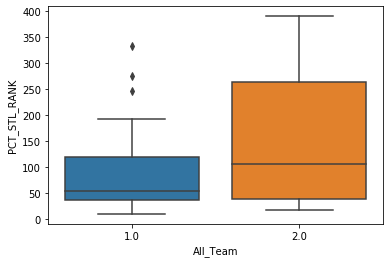

In [21]:
sns.boxplot(x = "All_Team", y = "PCT_STL_RANK", data = SF_Defense[SF_Defense['All_Team']!=3])

In [60]:
Separated_PG_df = classify_nominees(PG_Defense,Feature_Engineered_PG)
# Separated_SG_df = classify_nominees(SG_Defense,Feature_Engineered_SG)
# Separated_SF_df = classify_nominees(SF_Defense,Feature_Engineered_SF)
# Separated_PF_df = classify_nominees(PF_Defense,Feature_Engineered_PF)
# Separated_C_df = classify_nominees(C_Defense,Feature_Engineered_C)
# Separated_G_df = classify_nominees(G_Defense,Feature_Engineered_G)
# Separated_F_df = classify_nominees(F_Defense,Feature_Engineered_F)

Resampled dataset shape Counter({0.0: 789, 1.0: 789})


In [61]:
Separated_PG_df[Separated_PG_df['Year']==2017].sort_values(by='Defensive Team prob',ascending=False)

,id,Player,Year,Truth,Prediction,Normal prob,Defensive Team prob
155,11094,Ben Simmons,2017,3.0,1.0,0.097910,0.902090
196,11526,Ricky Rubio,2017,3.0,1.0,0.311036,0.688964
202,11573,Terry Rozier,2017,3.0,1.0,0.471722,0.528278
186,11404,Kyrie Irving,2017,3.0,1.0,0.543348,0.456652
157,11136,Chris Paul,2017,3.0,1.0,0.571566,0.428434
185,11401,Kyle Lowry,2017,3.0,0.0,0.922201,0.077799
200,11564,Stephen Curry,2017,3.0,0.0,0.930092,0.069908
191,11462,Mike Conley,2017,3.0,0.0,0.983062,0.016938
181,11347,John Wall,2017,3.0,0.0,0.985546,0.014454
161,11150,Damian Lillard,2017,3.0,0.0,0.991782,0.008218


In [24]:
# Separated_SF_df[Separated_SF_df['Year']==2018].sort_values(by='Defensive Team prob',ascending=False)

In [25]:
PG_model, All_team_PG_df = diffrenciate_nominees(PG_Defense,Feature_Engineered_Bin_PG)
SG_model, All_team_SG_df = diffrenciate_nominees(SG_Defense,Feature_Engineered_Bin_SG)
SF_model, All_team_SF_df = diffrenciate_nominees(SF_Defense,Feature_Engineered_Bin_SF)
PF_model, All_team_PF_df = diffrenciate_nominees(PF_Defense,Feature_Engineered_Bin_PF)
C_model, All_team_C_df = diffrenciate_nominees(C_Defense,Feature_Engineered_Bin_C)

Resampled dataset shape Counter({1.0: 21, 2.0: 21})
Resampled dataset shape Counter({1.0: 17, 2.0: 17})
Resampled dataset shape Counter({1.0: 18, 2.0: 18})
Resampled dataset shape Counter({2.0: 21, 1.0: 21})
Resampled dataset shape Counter({1.0: 22, 2.0: 22})


In [ ]:
All_team_SG_df

In [ ]:
predict_nominees(PG_model, PG_Defense, Feature_Engineered_Bin_PG,Separated_PG_df)

In [ ]:
predict_nominees(PF_model, PF_Defense, Feature_Engineered_Bin_PF,Separated_PF_df)

In [ ]:
predict_nominees(SG_model, SG_Defense, Feature_Engineered_Bin_SG,Separated_SG_df)

In [ ]:
# # Inital test that doesn't work
# def train_position (original_df,processed_df):
#     X = processed_df.loc[:,"W_PCT_RANK":"DEF_WS_RANK"]
#     X =((X-X.mean())/(X.std()))
#     Y = processed_df['All_Team']
#     x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
# # Comment/Uncomment for non-random test
# #     X['Year'] = processed_df['Year'].to_numpy() 
# #     Y = processed_df[['All_Team','Year']]
# #     x_train, x_test, y_train, y_test = latest_four_years(X,Y)
#     sm = SMOTE()
#     x_train, y_train = sm.fit_resample(x_train, y_train)
#     print('Resampled dataset shape %s' % Counter(y_train))
# #     model = tree.DecisionTreeClassifier().fit(x_train,y_train)
# #     model = SVC(max_iter=2000, probability=True).fit(x_train,y_train)
#     model = LogisticRegression(max_iter=2000).fit(x_train,y_train)
#     final_array = []
#     for i in y_test.index:
#         final_array.append([str(i), str(original_df["Player"].ix[[i]].values[0]), int(original_df["Year"].ix[[i]].values[0]), 
#         float(processed_df["All_Team"].ix[[i]].values[0]), float(model.predict(np.array(x_test.ix[[i]]).reshape(1,-1))[0]), 
#         float(model.predict_proba(np.array(x_test.ix[[i]]).reshape(1,-1))[0][0]), 
#         float(model.predict_proba(np.array(x_test.ix[[i]]).reshape(1,-1))[0][1]), 
#         float(model.predict_proba(np.array(x_test.ix[[i]]).reshape(1,-1))[0][2])])
#         final_df = pd.DataFrame(np.array(final_array), 
#                         columns=['id', 'Player', 'Year', 'Truth', 'Prediction', 'Prob1', 'Prob2', 'Prob3'])
#         final_df[["Year", "Truth", "Prediction",'Prob1', 'Prob2', 'Prob3']] = final_df[["Year", "Truth", "Prediction",'Prob1', 'Prob2', 'Prob3']].apply(pd.to_numeric)
#     return(final_df)
# #         print(str(i) + " " + "Name: " + str(original_df["Player"].ix[[i]].values[0]) + " " + "Year: " + str(original_df["Year"].ix[[i]].values[0]) + " " + str(processed_df["All_Team"].ix[[i]].values[0]) + " " + str(model.predict(np.array(x_test.ix[[i]]).reshape(1,-1))[0]) + " "+ str(model.predict_proba(np.array(x_test.ix[[i]]).reshape(1,-1))))

In [ ]:
PG_df = train_position(PG_Defense,Dummy_PG)
G_df = train_position(G_Defense,Dummy_G)
# PG_df = train_position(PG_Defense,Dummy_PG)
SG_df = train_position(SG_Defense,Dummy_SG)
F_df = train_position(F_Defense,Dummy_F)
C_df = train_position(C_Defense,Dummy_C)
SF_df = train_position(SF_Defense,Dummy_SF)
PF_df = train_position(PF_Defense,Dummy_PF)

In [ ]:
df = DataFrame()
for i in range (2014,2019):
    for j in range(1,3):
        df = pd.concat([df,G_df[G_df['Year']==i][G_df['Prediction']==j]])
        df = pd.concat([df,SF_df[SF_df['Year']==i][SF_df['Prediction']==j]])
        df = pd.concat([df,PF_df[PF_df['Year']==i][PF_df['Prediction']==j]])
        df = pd.concat([df,C_df[C_df['Year']==i][C_df['Prediction']==j]])

In [ ]:
SF_df[SF_df['Year']==2010].sort_values('Prob1',ascending=False)

In [ ]:
SVM_df = DataFrame()
for i in range (2014,2019):
    for j in range(1,3):
        prob = 'Prob'+ str(j)
        SVM_df = pd.concat([SVM_df,G_df[G_df['Year']==i].sort_values(prob, ascending= False).head(2)])
        SVM_df = pd.concat([SVM_df,SF_df[SF_df['Year']==i].sort_values(prob, ascending= False).head(1)])
        SVM_df = pd.concat([SVM_df,PF_df[PF_df['Year']==i].sort_values(prob, ascending= False).head(1)])
        SVM_df = pd.concat([SVM_df,C_df[C_df['Year']==i].sort_values(prob, ascending= False).head(1)])

In [ ]:
SVM_df.to_csv("svm.csv")

In [ ]:
LR_df = DataFrame()
for i in range (2014,2019):
    for j in range(1,3):
        prob = 'Prob'+ str(j)
        LR_df = pd.concat([LR_df,G_df[G_df['Year']==i].sort_values(prob, ascending= False).head(2)])
        LR_df = pd.concat([LR_df,SF_df[SF_df['Year']==i].sort_values(prob, ascending= False).head(1)])
        LR_df = pd.concat([LR_df,PF_df[PF_df['Year']==i].sort_values(prob, ascending= False).head(1)])
        LR_df = pd.concat([LR_df,C_df[C_df['Year']==i].sort_values(prob, ascending= False).head(1)])

In [ ]:
LR_df

In [ ]:
LR_df.to_csv("logistic_regression.csv")

In [ ]:
Bin_PG_df[Bin_PG_df['Year']==2018].sort_values(by='Prob2',ascending=False).head(10)

In [ ]:
All_team_PG_df.sort_values(by='Prob1',ascending=False)

In [ ]:
G_X = Dummy_G.loc[:,"W_PCT_RANK":"DEF_WS_RANK"]
G_X=((G_X-G_X.min())/(G_X.max()-G_X.min()))
G_Y = Dummy_G['All_Team']
# Binary Classifier
# G_Y[G_Y == 2] = 1
# G_Y[G_Y == 3] = 0
G_x_train, G_x_test, G_y_train, G_y_test = train_test_split(G_X, G_Y, test_size=0.25, random_state=0)

In [ ]:
G_sm = SMOTE(random_state=42)
G_x_train, G_y_train = G_sm.fit_resample(G_x_train, G_y_train)
print('Resampled dataset shape %s' % Counter(G_y_train))

In [ ]:
# Alternative model
G_model=OneVsOneClassifier(LinearSVC(random_state=0)).fit(G_x_train, G_y_train)

In [ ]:
G_model = LogisticRegression(max_iter=3000)
G_model.fit(G_x_train,G_y_train)
# G_coeff = DataFrame(list(zip(G_x_train.columns, np.transpose(G_model.coef_)[:,0],
#                               np.transpose(G_model.coef_)[:,1], np.transpose(G_model.coef_)[:,2])),
#                      columns = ['Feature','No Nomination','First Team','Second Team'])
# G_coeff.sort_values(by = "First Team" , ascending = False)

In [ ]:
for i in G_y_test.index:
    print(str(i) + " " + "Name: " + str(G_Defense["Player"].ix[[i]].values[0]) + " " + "Year: " + str(G_Defense["Year"].ix[[i]].values[0]) + " " + str(Dummy_G["All_Team"].ix[[i]].values[0]) + " " + str(G_model.predict(np.array(G_x_test.ix[[i]]).reshape(1,-1))) + " "+ str(G_model.predict_proba(np.array(G_x_test.ix[[i]]).reshape(1,-1))))

In [ ]:
print (G_model.score(G_x_test, G_y_test))
# print (recall_score(G_y_test, G_model.predict(G_x_test)))

In [ ]:
SF_X = Dummy_SF.loc[:,"W_PCT_RANK":"DEF_WS_RANK"]
SF_X=((SF_X-SF_X.min())/(SF_X.max()-SF_X.min()))
SF_Y = Dummy_SF['All_Team']
# Binary Classifier
# G_Y[G_Y == 2] = 1
# G_Y[G_Y == 3] = 0
SF_x_train, SF_x_test, SF_y_train, SF_y_test = train_test_split(SF_X, SF_Y, test_size=0.25, random_state=0)
# PF
PF_X = Dummy_PF.loc[:,"W_PCT_RANK":"DEF_WS_RANK"]
PF_X=((PF_X-PF_X.min())/(PF_X.max()-PF_X.min()))
PF_Y = Dummy_PF['All_Team']
# Binary Classifier
# G_Y[G_Y == 2] = 1
# G_Y[G_Y == 3] = 0
PF_x_train, PF_x_test, PF_y_train, PF_y_test = train_test_split(PF_X, PF_Y, test_size=0.25, random_state=0)

In [ ]:
SF_sm = SMOTE(random_state=42)
SF_x_train, SF_y_train = SF_sm.fit_resample(SF_x_train, SF_y_train)
print('Resampled dataset shape %s' % Counter(SF_y_train))
PF_sm = SMOTE(random_state=42)
PF_x_train, PF_y_train = PF_sm.fit_resample(PF_x_train, PF_y_train)
print('Resampled dataset shape %s' % Counter(PF_y_train))

In [ ]:
SF_model = LogisticRegression(max_iter=3000)
SF_model.fit(SF_x_train,SF_y_train)
PF_model = LogisticRegression(max_iter=3000)
PF_model.fit(PF_x_train,PF_y_train)

In [ ]:
for i in SF_y_test.index:
    print(str(i) + " " + "Name: " + str(SF_Defense["Player"].ix[[i]].values[0]) + " " + "Year: " + str(SF_Defense["Year"].ix[[i]].values[0]) + " " + str(Dummy_SF["All_Team"].ix[[i]].values[0]) + " " + str(SF_model.predict(np.array(SF_x_test.ix[[i]]).reshape(1,-1))) + " "+ str(SF_model.predict_proba(np.array(SF_x_test.ix[[i]]).reshape(1,-1))))

In [ ]:
for i in PF_y_test.index:
    print(str(i) + " " + "Name: " + str(PF_Defense["Player"].ix[[i]].values[0]) + " " + "Year: " + str(PF_Defense["Year"].ix[[i]].values[0]) + " " + str(Dummy_PF["All_Team"].ix[[i]].values[0]) + " " + str(PF_model.predict(np.array(PF_x_test.ix[[i]]).reshape(1,-1))) + " "+ str(PF_model.predict_proba(np.array(PF_x_test.ix[[i]]).reshape(1,-1))))